In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

In [2]:
df = pd.read_csv("/kaggle/input/emotions-in-text/Emotion_final.csv")

<AxesSubplot:xlabel='Emotion', ylabel='count'>

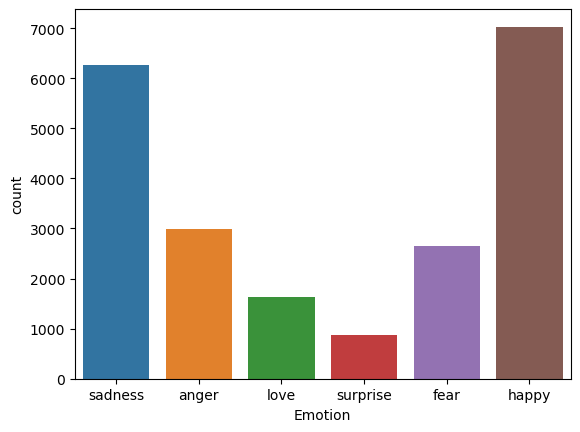

In [3]:
sns.countplot(x = "Emotion", data = df)

In [4]:
# upsample surprise
n_surp_sample = 1000
surp = df[df["Emotion"] == "surprise"]
surp_upsample = resample(surp, random_state = 35, n_samples=n_surp_sample, replace = True)

# upsample love
n_love_sample = 500
love = df[df["Emotion"] == "love"]
love_upsample = resample(love, random_state = 35, n_samples=n_love_sample, replace = True)

df = pd.concat([df, surp_upsample, love_upsample])

<AxesSubplot:xlabel='Emotion', ylabel='count'>

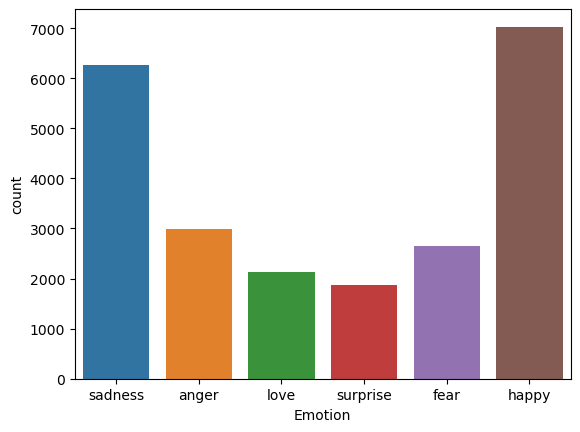

In [5]:
sns.countplot(x = "Emotion", data = df)

In [6]:
encoder = OneHotEncoder()
X = np.array(df.Text)
y = encoder.fit_transform(np.array(df.Emotion).reshape(-1,1)).toarray()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [8]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as tf_hub
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [9]:
def buil_model_with_bert():
    text_input = Input(shape=(), dtype=tf.string, name="text_input")
    
    preprocessor = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessor")
    encoder_inputs = preprocessor(text_input)
    
    encoder = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2", trainable=True, name="encoder")
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]
    
    net = Dense(512, activation="relu")(pooled_output)
    net = BatchNormalization()(net)
    net = Dropout(0.1)(net)
    net = Dense(512, activation="relu")(net)
    net = BatchNormalization()(net)
    net = Dropout(0.1)(net)
    net = Dense(256, activation="relu")(net)
    net = BatchNormalization()(net)
    net = Dropout(0.1)(net)
    net = Dense(128, activation="relu")(net)
    net = BatchNormalization()(net)
    net = Dropout(0.1)(net)
    net = Dense(units=6, activation='softmax')(net)
    
    return Model(inputs=text_input, outputs=net)

model = buil_model_with_bert()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [10]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
his = model.fit(x=X_train, y=y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
146/146 [==============================] - 157s 916ms/step - loss: 1.0155 - accuracy: 0.6546 - val_loss: 0.6561 - val_accuracy: 0.8065
Epoch 2/30
146/146 [==============================] - 136s 929ms/step - loss: 0.3314 - accuracy: 0.8863 - val_loss: 0.2833 - val_accuracy: 0.8974
Epoch 3/30
146/146 [==============================] - 133s 907ms/step - loss: 0.2096 - accuracy: 0.9223 - val_loss: 0.2596 - val_accuracy: 0.9095
Epoch 4/30
146/146 [==============================] - 121s 829ms/step - loss: 0.1544 - accuracy: 0.9411 - val_loss: 0.3295 - val_accuracy: 0.9115
Epoch 5/30
146/146 [==============================] - 130s 889ms/step - loss: 0.1375 - accuracy: 0.9494 - val_loss: 0.2963 - val_accuracy: 0.9149
Epoch 6/30
146/146 [==============================] - 128s 878ms/step - loss: 0.1078 - accuracy: 0.9616 - val_loss: 0.3451 - val_accuracy: 0.9105
Epoch 7/30
146/146 [==============================] - 128s 878ms/step - loss: 0.0911 - accuracy: 0.9673 - val_loss: 0.3586 -